# IMPORT

In [1]:
# import os
# import yaml
import glob
# import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
# Show all rows from pandas
# pd.set_option('display.max_rows', None)
# import xlwings as xw
# %matplotlib inline
# %matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

from dep.config import * # workbook, config, data
from dep.fonctions import (create_main_info_latex, insert_nb_de_cas_dans_latex, create_3D_plot, 
                            create_latex_table, create_latex_cas, fill_cas_in_excel, crop_image,
                            review_csv_groupes)

from dep.group import Group
from dep.cas import Cas

Chargement du fichier Excel TEMPLATE_DDC.xlsx
-----------------------------------------------
Chargement de la configuration des cas de test à partir du fichier Excel
last_row=22, last_col=9, nb_cas=7
{1: {'nom': 'Charges permanentes (G)', 'type_charge': 'individuelle', 'composantes': ['1-G'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 44.0, 'elevation': 26.0, 'zoom': 1.3, 'coef_RF': 0.4, 'pourcentage_pour_affichage': 0.5, 'top_crop': 500.0, 'bottom_crop': 1440.0, 'left_crop': 500.0, 'right_crop': 1650.0, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}, 2: {'nom': "Charges d'exploitation (Q)", 'type_charge': 'individuelle', 'composantes': ['2-Q'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 44.0, 'elevation': 26.0, 'zo

https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.stem.html#mpl_toolkits.mplot3d.axes3d.Axes3D.stem

# Execution 

In [2]:
GROUPES = dict()

groupe = review_csv_groupes(folder='./input_data/*.csv')
# Création du fichier main_infos.tex
# create_main_info_latex()
# insert_nb_de_cas_dans_latex(groupe=groupe)

for id in groupe:
    print(f"Groupe {id} en début de traitement")
    # Création d'un objet Groupe
    GROUPES[id]= Group(Groupe_id=id)
    # Chargement des coordonnées des points
    GROUPES[id].load_coordonnees()
    # Chargement des charges 
    GROUPES[id].load_ddc_individuelle()
    # Chargement des charges combinées
    GROUPES[id].load_ddc_combinee()
    # Merge des points et des charges individuelles
    GROUPES[id].merge_points_charges()
    # Initialisation de la liste des cas pour ce groupe
    GROUPES[id].dict_cas = dict()
    # Liste des cas uniques de charges individuelles
    print(f'Charges individuelles: {GROUPES[id].df_ddc_individuelle_points.Cas.unique()}')
    # Liste des cas uniques de charges combinées
    print(f'Charges combinées: {GROUPES[id].df_ddc_combinee.Designation.unique()}')
    
    print(f"Création des graphes et des tableaux")
    print('-----------------------------')
    for numero_cas in config.keys(): # Liste de cas
        if config[numero_cas]['groupe'] == id:
            print(f"Cas {numero_cas} en début de traitement")
            GROUPES[id].dict_cas[numero_cas] = Cas(nom = config[numero_cas]['nom'],
                                                    groupe=id,
                                                    config_cas=config[numero_cas])
            # Création du dataframe de cas
            GROUPES[id].dict_cas[numero_cas].df_cas = GROUPES[id].sort_df(numero_cas=numero_cas)
            # 
            # Calcul du facteur d'échelle et des valeurs min et max des axes ponctuels
            scale_factor, axe_min_max = GROUPES[id].calc_scale_factor(coef=config[numero_cas]['coef_RF'],
                                                                        cas=numero_cas)
            # Création des graphes ponctuel
            GROUPES[id].plot_graphes_reperage_points(numero_cas=numero_cas, axe_min_max=axe_min_max)
            create_3D_plot(df=GROUPES[id].dict_cas[numero_cas].df_cas, 
                        numero_cas=numero_cas, 
                        scale_factor=scale_factor,
                        axe_min_max=axe_min_max)
            # 
            if config[numero_cas]['type_groupe'] == 'lineaire':
                GROUPES[id].dict_cas[numero_cas].create_df_lineaire()
            
            print(f"Cas {numero_cas} terminé")
            print('-----------------------------')
    print(f"Traitement de Groupe {id} terminé")
############################################################################################################################
print('-----------------------------')
print('Cropping des images')
for im in glob.glob('assets/img/*.png'):
    print(im)
    if '3D' in im and 'cropped' not in im:  
        crop_image(img_path=im, top=int(config[numero_cas]['top_crop']), 
                    bottom=int(config[numero_cas]['bottom_crop']), 
                    left=int(config[numero_cas]['left_crop']), 
                    right=int(config[numero_cas]['right_crop']), 
                    show=False)
############################################################################################################################
print('Completed')

# Pour Latex, ne pas oublier de copier les fichiers à la racine puis de compiler by opening the Command Palette (Ctrl + Shift + P) and choosing
# LaTeX Workshop: Build LaTeX Project

['./input_data\\Groupe 1_Coordonées Points.csv', './input_data\\Groupe 1_DDC combinée.csv', './input_data\\Groupe 1_DDC individuelle.csv']
Liste des groupes dans le répertoire input data: [1]
Liste des groupes dans le fichier excel: [1]
Groupe 1 en début de traitement
Charges individuelles: ['1-G' '2-Q' '3-S' '4-W' '5-W2' '13-W3' '14-W4']
Charges combinées: ['ELU-STR']
Création des graphes et des tableaux
-----------------------------
Cas 1 en début de traitement
Le Cas choisi est : {'nom': 'Charges permanentes (G)', 'type_charge': 'individuelle', 'composantes': ['1-G'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 44.0, 'elevation': 26.0, 'zoom': 1.3, 'coef_RF': 0.4, 'pourcentage_pour_affichage': 0.5, 'top_crop': 500.0, 'bottom_crop': 1440.0, 'left_crop': 500.0, 'right_crop': 1650.0, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_

# Rapport excel

In [ ]:
print('Création des rapports')
# Selection de la feuille excel
sheet = workbook.sheets['DdC(FRA)']
for id in groupe:
    print(f"Groupe {id} en début d'écriture")    
    # Création des fichiers Latex et excel
    for numero_cas in config.keys(): # Liste de cas
        if config[numero_cas]['groupe'] == id:
            #
            if config[numero_cas]['type_groupe'] == 'ponctuel': 
                if config[numero_cas]['type_charge'] == 'individuelle':
                    df_cas = GROUPES[id].dict_cas[numero_cas].df_cas.loc[:,['Nom point', 'RFx_kN', 'RFy_kN', 'RFz_kN', 'X', 'Y', 'Z']]
                elif config[numero_cas]['type_charge'] == 'combinée':
                    df_cas = GROUPES[id].dict_cas[numero_cas].df_cas.loc[:,['Nom point', 'RFxmin_kN', 'RFxmax_kN', 'RFymin_kN', 'RFymax_kN', 'RFzmin_kN', 'RFzmax_kN', 'X', 'Y', 'Z']]
            elif config[numero_cas]['type_groupe'] == 'lineaire':
                df_cas = GROUPES[id].dict_cas[numero_cas].df_cas_lineique.loc[:,['Segments', 'RFx_kN/ml', 'RFy_kN/ml', 'RFz_kN/ml']]
            # # Création du fichier Latex
            # create_latex_table(df_latex=df_cas, numero_cas=numero_cas)
            # create_latex_cas(numero_cas=numero_cas) 
            # # Remplissage de la feuille excel
            fill_cas_in_excel(groupe=id, numero_cas=numero_cas, sheet=sheet, df_temp=df_cas)
            # Sauvegarde du fichier excel
workbook.save('./output_files/Resultats.xlsx')
print('Completed')

# Rapport word

In [20]:
from docx import Document
from docx.shared import Inches, Pt
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_TABLE_ALIGNMENT


# Open an existing Word document
doc = Document("./input_data/TEMPLATE_DDC.docx")

# Function to find a specific paragraph
def find_paragraph(doc, search_text):
    for i, paragraph in enumerate(doc.paragraphs):
        if search_text in paragraph.text:
            return i  # Return the index of the paragraph
    return -1  # Not found


# Search for a specific paragraph containing certain text
search_text = "Les descentes de charges sont données selon le repère global, pour chaque cas de charge considéré."
position = find_paragraph(doc, search_text)
position

125

In [21]:
def ajout_image(nom_fichier:str, titre_figure:str, size_inch:int):
    new_paragraph = doc.add_paragraph(titre_figure+"\n", style='Normal')
    image_path = r'C:\Users\nmorand\OneDrive - SIMONIN SAS\_Descente_de_charge\assets\img'+r'\\'+nom_fichier
    run = new_paragraph.add_run()
    run.add_picture(image_path, width=Inches(size_inch))
    new_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER

def format_header(cell, font_size=12):
    run = cell.paragraphs[0].runs[0]
    run.bold = True
    run.font.size = Pt(font_size)

def format_cell(cell, font_size=10):
    run = cell.paragraphs[0].runs[0]
    run.font.size = Pt(font_size)

def set_cell_border(cell, **kwargs):
    """
    Set cell borders for top, bottom, left, and right.
    Example usage:
    set_cell_border(cell, top={"sz": 12, "val": "single", "color": "000000", "space": "0"})
    """
    tc = cell._element
    tcPr = tc.get_or_add_tcPr()

    for border_name, border_attrs in kwargs.items():
        border = OxmlElement(f'w:{border_name}')
        for key, value in border_attrs.items():
            border.set(qn(f'w:{key}'), str(value))
        tcPr.append(border)


def ajout_table(df:pd.DataFrame):
    table = doc.add_table(rows=df.shape[0]+1, cols=df.shape[1]) # 'Table Grid'
    # Add the header row (column names)
    for j, col_name in enumerate(df.columns):
        header_cell = table.cell(0, j)
        header_cell.text = col_name
        format_header(header_cell, 12)
        # Apply borders to the header cell
        set_cell_border(
            header_cell,
            top={"sz": 12, "val": "single", "color": "000000", "space": "0"},
            bottom={"sz": 12, "val": "single", "color": "000000", "space": "0"},
            left={"sz": 12, "val": "single", "color": "000000", "space": "0"},
            right={"sz": 12, "val": "single", "color": "000000", "space": "0"}
        )
    # Add the DataFrame content row by row
    for i, row in df.iterrows():
        for j, value in enumerate(row):
            cell = table.cell(i + 1, j)
            cell.text = str(value)
            format_cell(cell, font_size=10)
            # Apply borders to the cell
            set_cell_border(
                cell,
                top={"sz": 6, "val": "single", "color": "000000", "space": "0"},
                bottom={"sz": 6, "val": "single", "color": "000000", "space": "0"},
                left={"sz": 6, "val": "single", "color": "000000", "space": "0"},
                right={"sz": 6, "val": "single", "color": "000000", "space": "0"}
            )
    # Center the table horizontally on the page
    table.alignment = WD_TABLE_ALIGNMENT.CENTER

num_figure = 1
for id in groupe:
    doc.add_heading(f"Repérage Groupe de points {id}\n", level=2)
    ajout_image(nom_fichier='reperage_points_appuis_gr_'+str(id)+'.png', 
                titre_figure="Figure: Repérage des points d'appuis 2D:", 
                size_inch=5)
    #
    ajout_image(nom_fichier='reperage_points_appuis_3D_gr_'+str(id)+'_cropped.png', 
                titre_figure="Figure: Repérage des points d'appuis 3D:", 
                size_inch=5)
    #
    ajout_table(GROUPES[id].df_coordonnees[['Nom point', 'X', 'Y', 'Z']])
    # Insert page break
    doc.add_page_break()
    for numero_cas in config.keys():
        if config[numero_cas]['groupe'] == id:
            print(f"Cas {numero_cas} en début d'écriture")
            # TITRE CAS
            doc.add_heading(f"Cas n°{numero_cas} - {config[numero_cas]['nom']}", level=3)
            # Table des données
            if config[numero_cas]['type_groupe'] == 'ponctuel':
                if config[numero_cas]['type_charge'] == 'individuelle':
                    df = GROUPES[id].dict_cas[numero_cas].df_cas.loc[:,['Nom point', 'RFx_kN', 'RFy_kN', 'RFz_kN']]
                elif config[numero_cas]['type_charge'] == 'combinée':
                    df = GROUPES[id].dict_cas[numero_cas].df_cas.loc[:,['Nom point', 'RFxmin_kN', 'RFxmax_kN', 'RFymin_kN', 'RFymax_kN', 'RFzmin_kN', 'RFzmax_kN']]
                ajout_table(df)
            elif config[numero_cas]['type_groupe'] == 'lineaire':
                df = GROUPES[id].dict_cas[numero_cas].df_cas_lineique.loc[:,['Segments', 'RFx_kN/ml', 'RFy_kN/ml', 'RFz_kN/ml']]
                ajout_table(df)
            else:
                print("Type de groupe non reconnu")
            # Erase df
            del df
            # Graphe
            for graphe in ['RFx_kN', 'RFy_kN', 'RFz_kN']:
                ajout_image(nom_fichier='graph3D_charges_cas_'+str(numero_cas)+'_'+graphe.replace('Graphe_','')+'_cropped.png', 
                            titre_figure=f"Figure: Chargement en kN suivant {graphe} \n", 
                            size_inch=5)
            # Insert page break
            doc.add_page_break()

    # Save the document
    doc.save("./output_files/Resultats.docx")
    print('Completed')


Cas 1 en début d'écriture
Cas 2 en début d'écriture
Cas 3 en début d'écriture
Cas 4 en début d'écriture
Cas 5 en début d'écriture
Cas 6 en début d'écriture
Cas 7 en début d'écriture
Completed


## Analyse Manuelle

In [3]:
GROUPES = dict()
groupe = review_csv_groupes(folder='./input_data/*.csv')
groupe

['./input_data\\Groupe 1_Coordonées Points.csv', './input_data\\Groupe 1_DDC combinée.csv', './input_data\\Groupe 1_DDC individuelle.csv']
Liste des groupes dans le répertoire input data: [1]
Liste des groupes dans le fichier excel: [1]


[1]

In [4]:
id = 1
GROUPES[id]= Group(Groupe_id=id)

In [5]:
GROUPES[id].load_coordonnees()
GROUPES[id].df_coordonnees

,Point,Nom point,X,Y,Z,axe_lettre,axe_chiffre
0,56,56,12300,0,-4330,-,NaN
1,64,64,12300,16800,-4330,-,NaN
2,75,75,0,2040,-4330,-,NaN
3,200,200,12300,13930,-4330,-,NaN
4,204,204,4745,0,-4330,-,NaN
5,208,208,0,13320,-4330,-,NaN
6,63,63,12300,18450,-4330,-,NaN
7,68,68,2050,0,-4330,-,NaN
8,184,184,12300,21300,-4330,-,NaN
9,202,202,9460,0,-4330,-,NaN


In [8]:
GROUPES[id].load_ddc_individuelle()
GROUPES[id].df_ddc_individuelle

,Point,Nom point,Cas,RFx,RFy,RFz,RFx_kN,RFy_kN,RFz_kN,Iteration_#,Type_chargement
0,56,56,1-G,34,0,25630,0.34,0.00,256.30,1,G
1,56,56,2-Q,44,0,16019,0.44,0.00,160.19,2,Q
2,56,56,3-S,3,0,1210,0.03,0.00,12.10,3,S
3,56,56,4-W,-1585,0,5101,-15.85,0.00,51.01,4,W
4,56,56,5-W2,-225,-163,458,-2.25,-1.63,4.58,5,W2
...,...,...,...,...,...,...,...,...,...,...,...
72,206,206,3-S,0,-3,984,0.00,-0.03,9.84,3,S
73,206,206,4-W,-299,-4348,6150,-2.99,-43.48,61.50,4,W
74,206,206,5-W2,0,-1031,1529,0.00,-10.31,15.29,5,W2
75,206,206,13-W3,299,4457,-6303,2.99,44.57,-63.03,13,W3


In [9]:
GROUPES[id].load_ddc_combinee()
GROUPES[id].df_ddc_combinee

,Point,Nom point,RFxmin,Cas_RFxmin,RFxmax,Cas_RFxmax,RFymin,Cas_RFymin,RFymax,Cas_RFymax,...,Cas_RFzmin,RFzmax,Cas_RFzmax,Designation,RFxmin_kN,RFxmax_kN,RFymin_kN,RFymax_kN,RFzmin_kN,RFzmax_kN
0,56,56,-2343,59: G+1.5W,2535,33: 1.35G+1.5W3+1.05Q+0.75S,-244,63: G+1.5W2,244,37: 1.35G+1.5W4+1.05Q+0.75S,...,67: G+1.5W3,64128,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-23.43,25.35,-2.44,2.44,177.76,641.28
1,184,184,-245,25: 1.35G+1.5W+1.05Q+0.75S,245,67: G+1.5W3,-2276,67: G+1.5W3,3086,25: 1.35G+1.5W+1.05Q+0.75S,...,59: G+1.5W,24754,33: 1.35G+1.5W3+1.05Q+0.75S,ELU-STR,-2.45,2.45,-22.76,30.86,33.51,247.54
2,63,63,-245,25: 1.35G+1.5W+1.05Q+0.75S,245,67: G+1.5W3,-2277,67: G+1.5W3,3086,25: 1.35G+1.5W+1.05Q+0.75S,...,67: G+1.5W3,33435,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-2.45,2.45,-22.77,30.86,88.94,334.35
3,64,64,-247,25: 1.35G+1.5W+1.05Q+0.75S,247,67: G+1.5W3,-3174,33: 1.35G+1.5W3+1.05Q+0.75S,2204,59: G+1.5W,...,59: G+1.5W,26078,10: 1.35G+1.5Q+0.75S+0.9W3,ELU-STR,-2.47,2.47,-31.74,22.04,54.23,260.78
4,68,68,-7332,25: 1.35G+1.5W+1.05Q+0.75S,7374,67: G+1.5W3,-4542,67: G+1.5W3,4623,25: 1.35G+1.5W+1.05Q+0.75S,...,25: 1.35G+1.5W+1.05Q+0.75S,2864,67: G+1.5W3,ELU-STR,-73.32,73.74,-45.42,46.23,-59.49,28.64
5,204,204,-2377,62: G+1.5W+1.05Q+0.75S,2445,30: 1.35G+1.5W3,-232,63: G+1.5W2,232,35: 1.35G+1.5W4+1.05Q,...,67: G+1.5W3,11203,25: 1.35G+1.5W+1.05Q+0.75S,ELU-STR,-23.77,24.45,-2.32,2.32,-31.10,112.03
6,75,75,-1498,33: 1.35G+1.5W3+1.05Q+0.75S,1317,59: G+1.5W,-8649,59: G+1.5W,8915,33: 1.35G+1.5W3+1.05Q+0.75S,...,59: G+1.5W,35960,33: 1.35G+1.5W3+1.05Q+0.75S,ELU-STR,-14.98,13.17,-86.49,89.15,-65.17,359.60
7,208,208,-86,25: 1.35G+1.5W+1.05Q+0.75S,120,67: G+1.5W3,0,59: G+1.5W,0,33: 1.35G+1.5W3+1.05Q+0.75S,...,71: G+1.5W4,180333,9: 1.35G+1.5Q+0.75S+0.9W2,ELU-STR,-0.86,1.20,0.00,0.00,817.07,1803.33
8,200,200,-247,25: 1.35G+1.5W+1.05Q+0.75S,247,67: G+1.5W3,-3174,33: 1.35G+1.5W3+1.05Q+0.75S,2204,59: G+1.5W,...,67: G+1.5W3,143070,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-2.47,2.47,-31.74,22.04,516.41,1430.70
9,202,202,-2353,59: G+1.5W,2544,33: 1.35G+1.5W3+1.05Q+0.75S,-244,63: G+1.5W2,244,37: 1.35G+1.5W4+1.05Q+0.75S,...,59: G+1.5W,50870,10: 1.35G+1.5Q+0.75S+0.9W3,ELU-STR,-23.53,25.44,-2.44,2.44,176.06,508.70


In [10]:
GROUPES[id].merge_points_charges()
display(GROUPES[id].df_ddc_individuelle_points)
display(GROUPES[id].df_ddc_combinee_points)

,Point_x,Nom point,X,Y,Z,axe_lettre,axe_chiffre,Point_y,Cas,RFx,RFy,RFz,RFx_kN,RFy_kN,RFz_kN,Iteration_#,Type_chargement
0,56,56,12300,0,-4330,-,NaN,56,1-G,34,0,25630,0.34,0.00,256.30,1,G
1,56,56,12300,0,-4330,-,NaN,56,2-Q,44,0,16019,0.44,0.00,160.19,2,Q
2,56,56,12300,0,-4330,-,NaN,56,3-S,3,0,1210,0.03,0.00,12.10,3,S
3,56,56,12300,0,-4330,-,NaN,56,4-W,-1585,0,5101,-15.85,0.00,51.01,4,W
4,56,56,12300,0,-4330,-,NaN,56,5-W2,-225,-163,458,-2.25,-1.63,4.58,5,W2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,206,206,0,7250,-4330,-,NaN,206,3-S,0,-3,984,0.00,-0.03,9.84,3,S
73,206,206,0,7250,-4330,-,NaN,206,4-W,-299,-4348,6150,-2.99,-43.48,61.50,4,W
74,206,206,0,7250,-4330,-,NaN,206,5-W2,0,-1031,1529,0.00,-10.31,15.29,5,W2
75,206,206,0,7250,-4330,-,NaN,206,13-W3,299,4457,-6303,2.99,44.57,-63.03,13,W3


,Point_x,Nom point,X,Y,Z,axe_lettre,axe_chiffre,Point_y,RFxmin,Cas_RFxmin,...,Cas_RFzmin,RFzmax,Cas_RFzmax,Designation,RFxmin_kN,RFxmax_kN,RFymin_kN,RFymax_kN,RFzmin_kN,RFzmax_kN
0,184,184,12300,21300,-4330,-,NaN,184,-245,25: 1.35G+1.5W+1.05Q+0.75S,...,59: G+1.5W,24754,33: 1.35G+1.5W3+1.05Q+0.75S,ELU-STR,-2.45,2.45,-22.76,30.86,33.51,247.54
1,200,200,12300,13930,-4330,-,NaN,200,-247,25: 1.35G+1.5W+1.05Q+0.75S,...,67: G+1.5W3,143070,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-2.47,2.47,-31.74,22.04,516.41,1430.70
2,202,202,9460,0,-4330,-,NaN,202,-2353,59: G+1.5W,...,59: G+1.5W,50870,10: 1.35G+1.5Q+0.75S+0.9W3,ELU-STR,-23.53,25.44,-2.44,2.44,176.06,508.70
3,204,204,4745,0,-4330,-,NaN,204,-2377,62: G+1.5W+1.05Q+0.75S,...,67: G+1.5W3,11203,25: 1.35G+1.5W+1.05Q+0.75S,ELU-STR,-23.77,24.45,-2.32,2.32,-31.10,112.03
4,206,206,0,7250,-4330,-,NaN,206,-448,23: 1.35G+1.5W+1.05Q,...,67: G+1.5W3,55026,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-4.48,4.48,-66.49,66.24,114.61,550.26
5,208,208,0,13320,-4330,-,NaN,208,-86,25: 1.35G+1.5W+1.05Q+0.75S,...,71: G+1.5W4,180333,9: 1.35G+1.5Q+0.75S+0.9W2,ELU-STR,-0.86,1.20,0.00,0.00,817.07,1803.33
6,56,56,12300,0,-4330,-,NaN,56,-2343,59: G+1.5W,...,67: G+1.5W3,64128,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-23.43,25.35,-2.44,2.44,177.76,641.28
7,63,63,12300,18450,-4330,-,NaN,63,-245,25: 1.35G+1.5W+1.05Q+0.75S,...,67: G+1.5W3,33435,8: 1.35G+1.5Q+0.75S+0.9W,ELU-STR,-2.45,2.45,-22.77,30.86,88.94,334.35
8,64,64,12300,16800,-4330,-,NaN,64,-247,25: 1.35G+1.5W+1.05Q+0.75S,...,59: G+1.5W,26078,10: 1.35G+1.5Q+0.75S+0.9W3,ELU-STR,-2.47,2.47,-31.74,22.04,54.23,260.78
9,68,68,2050,0,-4330,-,NaN,68,-7332,25: 1.35G+1.5W+1.05Q+0.75S,...,25: 1.35G+1.5W+1.05Q+0.75S,2864,67: G+1.5W3,ELU-STR,-73.32,73.74,-45.42,46.23,-59.49,28.64


In [11]:
# Liste des cas
config.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

In [12]:
numero_cas = 1
GROUPES[id].dict_cas = dict()
if config[numero_cas]['groupe'] == id:
    print(f"Cas {numero_cas} en début de traitement")
    GROUPES[id].dict_cas[numero_cas] = Cas(nom = config[numero_cas]['nom'],
                                            groupe=id,
                                            config_cas=config[numero_cas])
    # Création du dataframe de cas
    GROUPES[id].dict_cas[numero_cas].df_cas = GROUPES[id].sort_df(numero_cas=numero_cas)
    # 
    # Calcul du facteur d'échelle et des valeurs min et max des axes ponctuels
    scale_factor, axe_min_max = GROUPES[id].calc_scale_factor(coef=config[numero_cas]['coef_RF'],
                                                                cas=numero_cas)
GROUPES[id].dict_cas[numero_cas].df_cas

Cas 1 en début de traitement
Le Cas choisi est : {'nom': 'Charges permanentes (G)', 'type_charge': 'individuelle', 'composantes': ['1-G'], 'type_combinaison': 'sum', 'col_ref': 235, 'row_ref': 11, 'groupe': 1, 'type_groupe': 'ponctuel', 'segments_pour_groupe_lineaire': None, 'azimuth': 44.0, 'elevation': 26.0, 'zoom': 1.3, 'coef_RF': 0.4, 'pourcentage_pour_affichage': 0.5, 'top_crop': 500.0, 'bottom_crop': 1440.0, 'left_crop': 500.0, 'right_crop': 1650.0, 'valeur_mini_affichage_RFx_kN': 1.0, 'valeur_mini_affichage_RFy_kN': 1.0, 'valeur_mini_affichage_RFz_kN': 1.0}
Lmax 8520.0
min_scale_factor 10.310900267454103
Axe_min -4330.0
Axe_max 21300.0
int(scale_factor_X)=172, int(scale_factor_Y)=143, int(scale_factor_Z)=10


,Nom point,RFx_kN,RFy_kN,RFz_kN,Point,X,Y,Z,axe_lettre,axe_chiffre
0,184,0.00,2.86,99.66,184,12300,21300,-4330,-,NaN
1,200,0.00,-2.95,585.64,200,12300,13930,-4330,-,NaN
2,202,0.33,0.00,219.61,202,9460,0,-4330,-,NaN
3,204,0.07,0.00,33.98,204,4745,0,-4330,-,NaN
4,206,0.00,-0.61,209.15,206,0,7250,-4330,-,NaN
5,208,0.00,0.00,826.31,208,0,13320,-4330,-,NaN
6,56,0.34,0.00,256.30,56,12300,0,-4330,-,NaN
7,63,0.00,2.86,139.23,63,12300,18450,-4330,-,NaN
8,64,0.00,-2.95,99.42,64,12300,16800,-4330,-,NaN
9,68,-0.37,0.62,-6.54,68,2050,0,-4330,-,NaN


## Contenu des groupes

In [6]:
for gr in groupe:
    # Liste des attributs de l'objet GROUPES[0]
    attributes = [attr for attr in dir(GROUPES[gr]) if not callable(getattr(GROUPES[gr], attr)) and not attr.startswith('__')]
    print("Attributes:", attributes)
    methods = [method for method in dir(GROUPES[gr]) if callable(getattr(GROUPES[gr], method)) and not method.startswith('__')]
    print("Methods:", methods)

Attributes: ['groupe_id']
Methods: ['calc_scale_factor', 'load_coordonnees', 'load_ddc_combinee', 'load_ddc_individuelle', 'merge_points_charges', 'plot_graphes_reperage_points', 'sort_df']


# Pour trouver la bonne orientation des graphes 3D

interactive(children=(FloatSlider(value=26.0, description='Elevation:', max=90.0, step=1.0), FloatSlider(value…

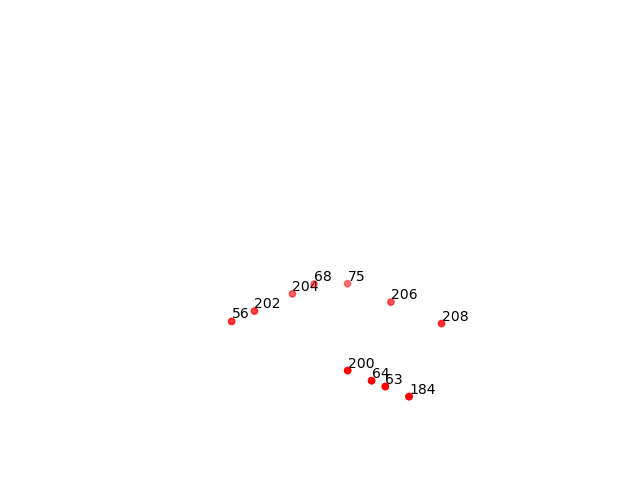

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.image as mpimg
%matplotlib inline
%matplotlib widget


# bg_img = mpimg.imread('input_data/image_structure.png') 
id = 1
numero_cas = 1
# Plot 3D plot of the df_ddc_individuelle 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type = 'ortho')

# img = mpimg.imread('input_data/image_structure.png')

# Define the coordinates where the image will be placed (e.g., on the XY plane)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zval = np.min(ax.get_zlim())  # Lowest z value
# Display the image on the XY plane at z = zval
# ax.imshow(img, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], origin='lower', zorder=-1)

ax.scatter(GROUPES[id].df_coordonnees['X'], GROUPES[id].df_coordonnees['Y'], GROUPES[id].df_coordonnees['Z'], c='r', marker='o')
#
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(axe_min_max[0],axe_min_max[1])
ax.set_ylim(axe_min_max[0],axe_min_max[1])
ax.set_zlim(axe_min_max[0],axe_min_max[1])
ax.set_axis_off()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Hide the axes

for i, txt in GROUPES[id].df_coordonnees.iterrows():
    ax.text(txt['X'], txt['Y'],txt['Z'], txt['Nom point'], ha='left', va='bottom')


# Define the update function for sliders
def update(elev, azim, zoom):
    ax.scatter(GROUPES[id].df_coordonnees['X'], GROUPES[id].df_coordonnees['Y'], GROUPES[id].df_coordonnees['Z'], c='r', marker='o')
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect(None, zoom=zoom)
    fig.canvas.draw_idle()

# Create sliders
elev_slider = widgets.FloatSlider(value=config[numero_cas]['elevation'], min=0, max=90, step=1, description='Elevation:')
azim_slider = widgets.FloatSlider(value=config[numero_cas]['azimuth'], min=0, max=360, step=1, description='Azimuth:')
zoom_slider = widgets.FloatSlider(value=config[numero_cas]['zoom'], min=1, max=10, step=0.1, description='Zoom:')

# Link sliders to update function
widgets.interactive(update, elev=elev_slider, azim=azim_slider, zoom=zoom_slider)

# Display the sliders
# display(elev_slider, azim_slider, zoom_slider)
